# Домашнее задание №3

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW3 <Фамилия Имя>**

soft deadline: 21.03.2021T23:59:00+0300

hard deadline: 28.03.2021T23:59:00+0300


In [1]:
from os.path import join
from os import listdir
from typing import List

import cv2
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

%matplotlib inline
plt.style.use('default')

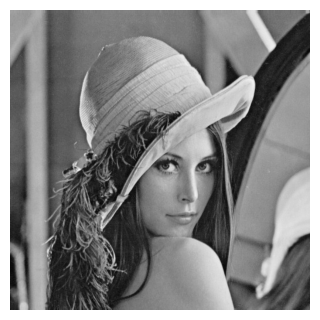

In [2]:
def show(img, size=3):
    plt.figure(figsize=(size, size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def gray_show(img, size=3):
    plt.figure(figsize=(size, size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap='gray')

lena = cv2.imread("lena.jpg")
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
gray_show(lena_gray)

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [3]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale, sigma_scale=1.5 / 6, psi=0):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    size = (size, size) if isinstance(size, int) else size

    lambdas = np.linspace(min_scale, max_scale, scale_bins)
    thetas = np.linspace(0, np.pi, phi_bins, endpoint=False)
    filters = np.zeros((scale_bins, phi_bins, *size))
    for i, lam in enumerate(lambdas):
        sigma = sigma_scale * lam
        for j, theta in enumerate(thetas):
            filters[i, j] = cv2.getGaborKernel(size, sigma, theta, lam, gamma=1, psi=psi)
            mask = filters[i, j] > 0
            filters[i, j][mask] /= np.sum(filters[i, j][mask])
            filters[i, j][~mask] /= np.abs(np.sum(filters[i, j][~mask]))
    return filters

In [4]:
size = 31
angle_bins = 180
scale_bins = 30

widget_scale = widgets.IntSlider(min=0, max=scale_bins - 1, step=1, value=15)
widget_angle = widgets.IntSlider(min=0, max=angle_bins - 1, step=1, value=0)

filters_bank = gabour_bank(size, angle_bins, scale_bins, size, 3)

@widgets.interact(scale=widget_scale, angle=widget_angle)
def show_gabour_filter(scale, angle, eps=widgets.fixed(1e-8)):
    kernel = filters_bank[scale, angle]
    
    fft = np.fft.fft2(kernel)
    fft_shift = np.fft.fftshift(fft)
    ms = np.log(np.abs(fft_shift) + eps)
    
    filter_img = cv2.filter2D(lena_gray, -1, kernel)

    fig, ax = plt.subplots(1, 3, figsize=(size, size * 3))

    ax[0].imshow(kernel, 'gray')
    ax[0].set_title("Kernel")
    ax[0].axis("off")

    ax[1].imshow(ms, 'gray')
    ax[1].set_title("Freq")
    ax[1].axis("off")

    ax[2].imshow(filter_img, 'gray')
    ax[2].set_title("Filtered")
    ax[2].axis("off")
    
    plt.show()

interactive(children=(IntSlider(value=15, description='scale', max=29), IntSlider(value=0, description='angle'…

**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 репрезентативных к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [5]:
class ImageDataset:
    def __init__(self, path: str, n_points: int = 100):
        self._path = join(path, "pic")
        self._images = listdir(self._path)

        self._n_points = n_points
        self._sift = cv2.SIFT_create(n_points)
        
        self._keypoints = [None for _ in range(len(self._images))]
        self._descriptors = [None for _ in range(len(self._images))]

    def _upload_with_sift(self, item: int) -> np.ndarray:
        image = cv2.imread(join(self._path, self._images[item]))
        if self._keypoints[item] is None:
            k, d = self._sift.detectAndCompute(image, None)
            if k is not None and d is not None:
                self._keypoints[item] = k
                self._descriptors[item] = d
        return image
    
    def __getitem__(self, item: int) -> np.ndarray:
        return self._upload_with_sift(item)

    def descriptors(self, item: int) -> np.ndarray:
        return self._descriptors[item]
    
    def keypoints(self, item: int) -> np.ndarray:
        return self._keypoints[item]
    
    def __len__(self) -> int:
        return len(self._images)

    def prepare_descriptors(self) -> int:
        wrong_images = 0
        for i in tqdm(range(len(self._images)), total=len(self._images)):
            self._upload_with_sift(i)
            if self._keypoints[i] is None or self._descriptors[i] is None:
                wrong_images += 1
        return wrong_images

In [6]:
def show_with_keypoints(image: np.ndarray, keypoints: List, size: int = 7):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 2, figsize=(size, size * 2))
    
    ax[0].imshow(image)
    ax[0].set_title("Original")
    ax[0].axis("off")

    kpt_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax[1].imshow(kpt_image)
    ax[1].set_title("With keypoints")
    ax[1].axis("off")
    plt.show()

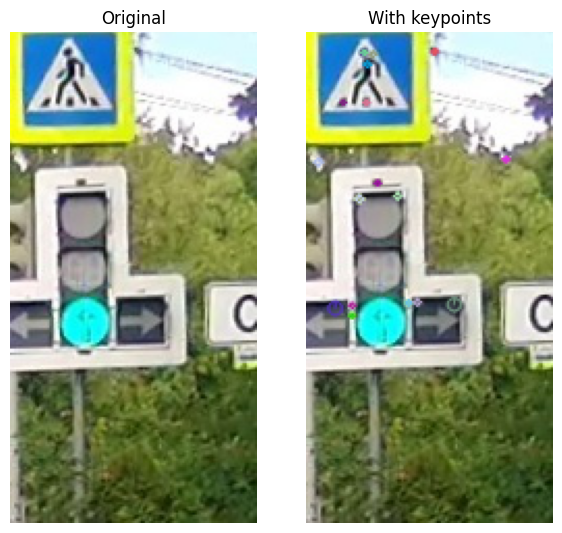

In [7]:
train_val = ImageDataset("./data/train_val/", n_points=25)
show_with_keypoints(train_val[0], train_val.keypoints(0))

In [8]:
train_val.prepare_descriptors()

  0%|          | 0/45633 [00:00<?, ?it/s]

28

In [9]:
visual_words = []
visual_words_kpt = []
visual_words_img_idx = []

for i in tqdm(range(len(train_val)), total=len(train_val)):
    d = train_val.descriptors(i)
    k = train_val.keypoints(i)
    if d is None or k is None:
        continue
    visual_words.append(d)
    visual_words_kpt += k
    visual_words_img_idx += [i for _ in range(len(d))]

visual_words = np.vstack(visual_words)

assert len(visual_words) == len(visual_words_kpt) == len(visual_words_img_idx)

  0%|          | 0/45633 [00:00<?, ?it/s]

In [10]:
visual_words.shape

(1101915, 128)

In [11]:
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=7, verbose=1, n_init=1)
cluster_ids = kmeans.fit_predict(visual_words)

Initialization complete
Iteration 0, inertia 164153442304.0
Iteration 1, inertia 107820048384.0
Iteration 2, inertia 105818693632.0
Iteration 3, inertia 105089351680.0
Iteration 4, inertia 104693874688.0
Iteration 5, inertia 104453046272.0
Iteration 6, inertia 104303173632.0
Iteration 7, inertia 104203526144.0
Iteration 8, inertia 104125071360.0
Iteration 9, inertia 104065712128.0
Iteration 10, inertia 104016470016.0
Iteration 11, inertia 103972724736.0
Iteration 12, inertia 103933845504.0
Iteration 13, inertia 103902879744.0
Iteration 14, inertia 103875960832.0
Iteration 15, inertia 103851802624.0
Iteration 16, inertia 103832010752.0
Iteration 17, inertia 103816347648.0
Iteration 18, inertia 103798685696.0
Iteration 19, inertia 103785439232.0
Iteration 20, inertia 103773028352.0
Iteration 21, inertia 103759347712.0
Iteration 22, inertia 103745167360.0
Iteration 23, inertia 103728734208.0
Iteration 24, inertia 103709368320.0
Iteration 25, inertia 103688192000.0
Iteration 26, inertia 10

In [12]:
%%time
distances = np.linalg.norm(kmeans.cluster_centers_[cluster_ids] - visual_words, axis=-1)

CPU times: user 499 ms, sys: 404 ms, total: 903 ms
Wall time: 904 ms


In [13]:
top_k = 5
buckets = [[] for _ in range(n_clusters)]

for i in tqdm(np.argsort(distances)):
    if len(buckets[cluster_ids[i]]) == top_k:
        continue
    buckets[cluster_ids[i]].append((visual_words_kpt[i], visual_words_img_idx[i]))

  0%|          | 0/1101915 [00:00<?, ?it/s]

Cluster #0


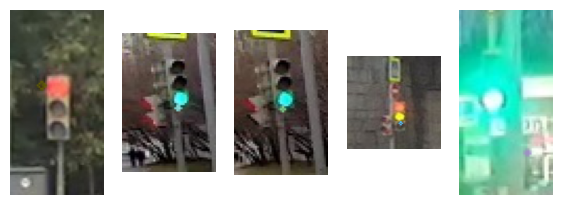

Cluster #1


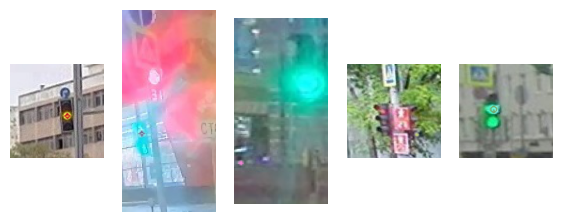

Cluster #2


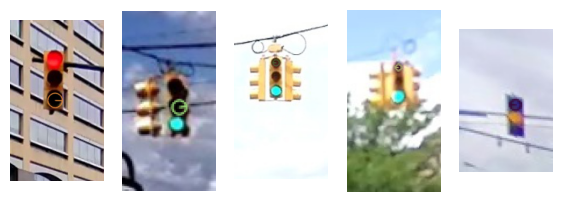

Cluster #3


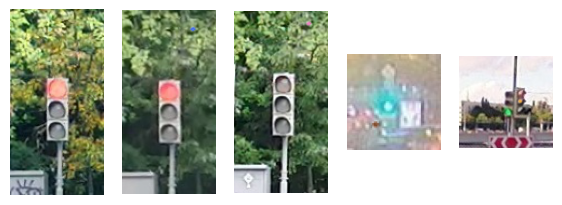

Cluster #4


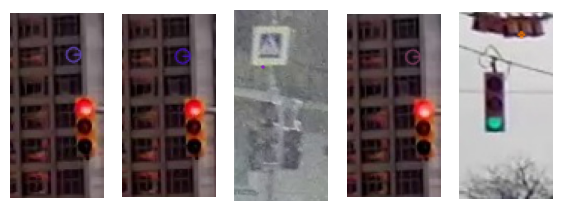

Cluster #5


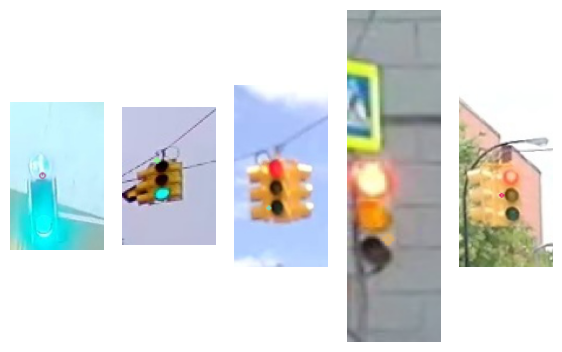

Cluster #6


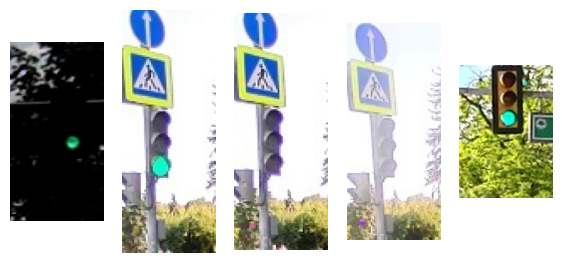

Cluster #7


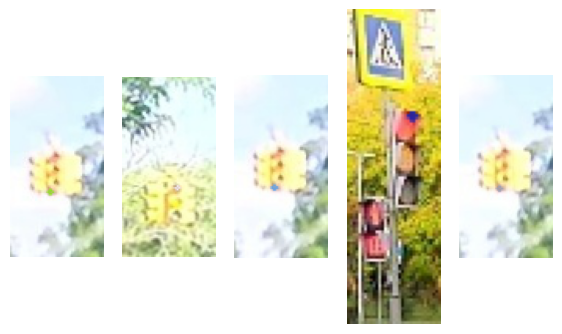

Cluster #8


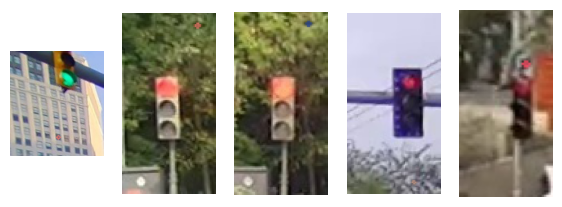

Cluster #9


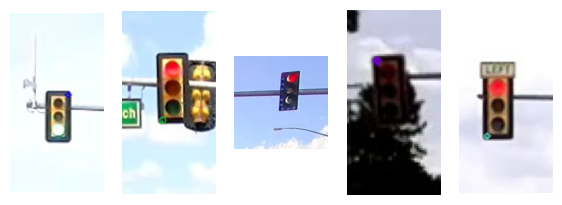

Cluster #10


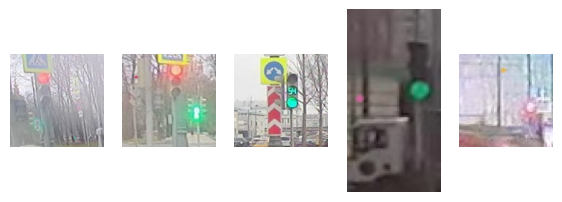

Cluster #11


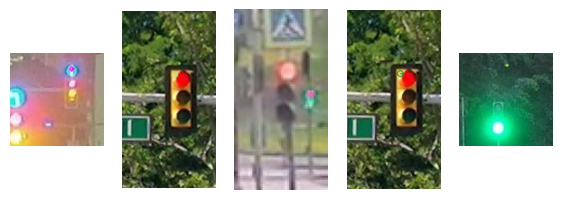

Cluster #12


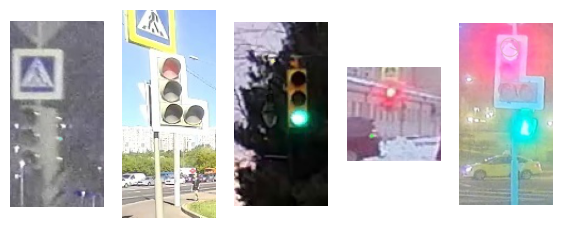

Cluster #13


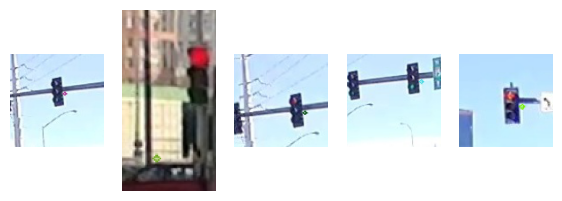

Cluster #14


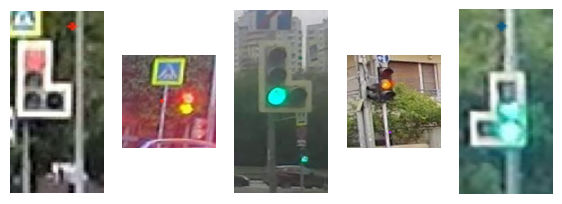

Cluster #15


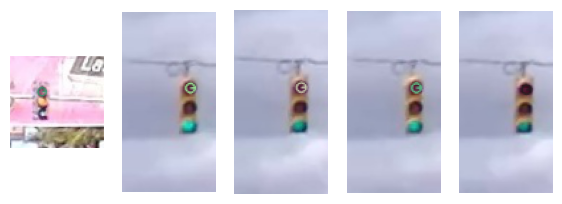

Cluster #16


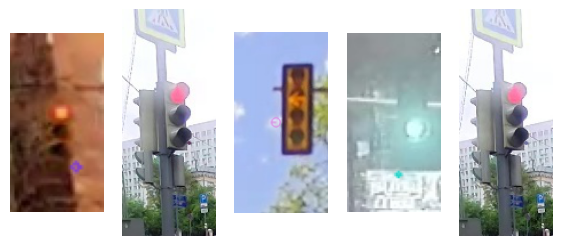

Cluster #17


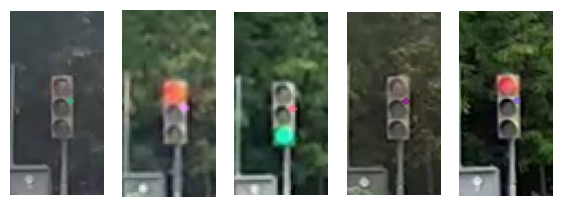

Cluster #18


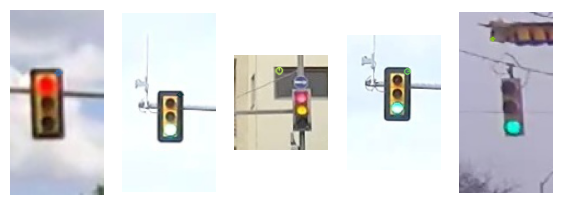

Cluster #19


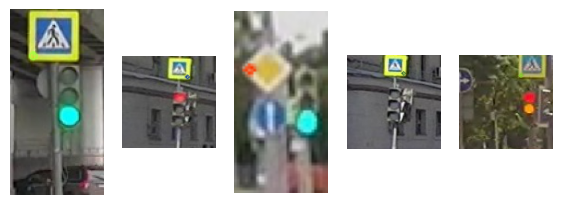

Cluster #20


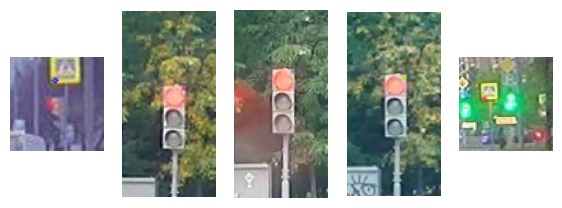

Cluster #21


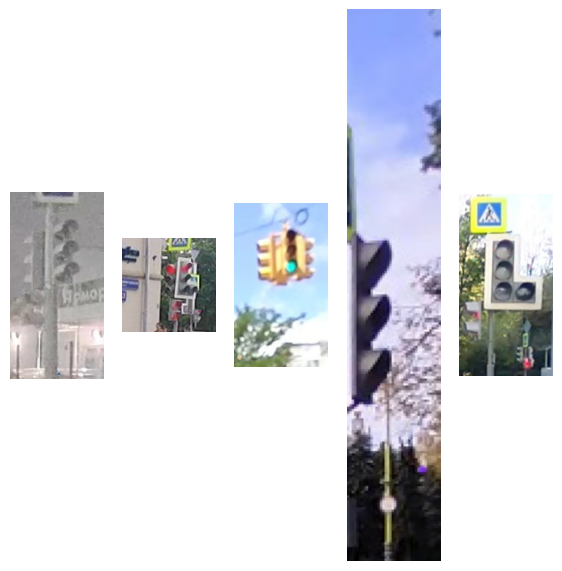

Cluster #22


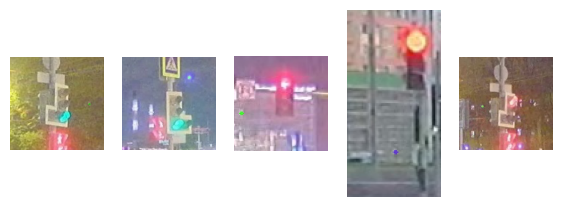

Cluster #23


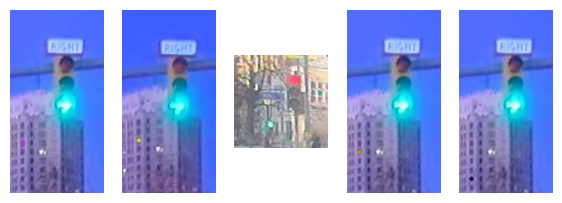

Cluster #24


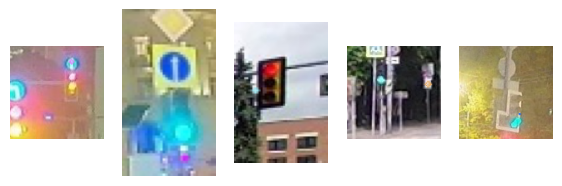

Cluster #25


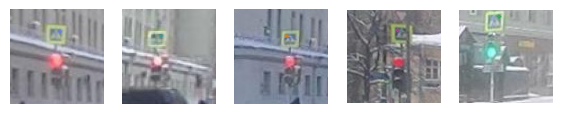

Cluster #26


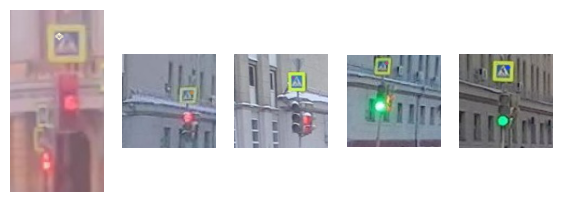

Cluster #27


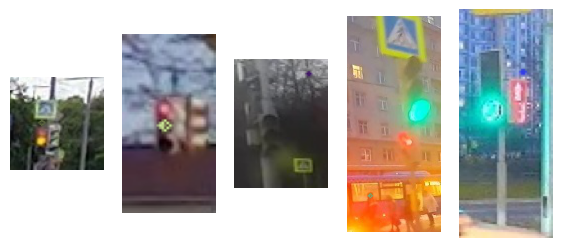

Cluster #28


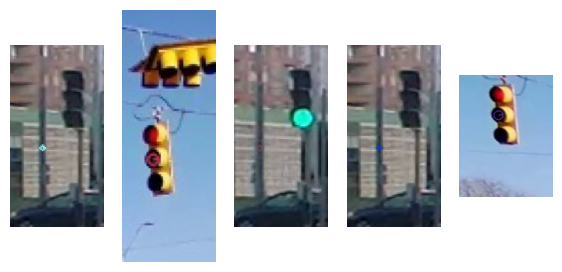

Cluster #29


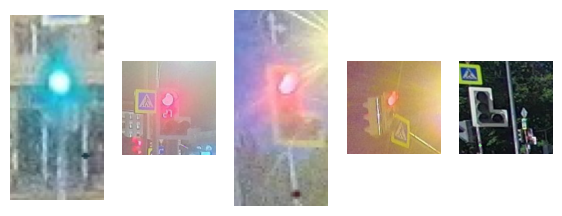

In [14]:
size = 7
for i, bucket in enumerate(buckets):
    print(f"Cluster #{i}")
    fig, ax = plt.subplots(1, top_k, figsize=(size, size * top_k))

    for j in range(top_k):
        image = cv2.cvtColor(train_val[bucket[j][1]], cv2.COLOR_BGR2RGB)
        kpt_image = cv2.drawKeypoints(
            image, [bucket[j][0]], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        ax[j].imshow(kpt_image)
        ax[j].axis("off")
    plt.show()

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/65dc3b38e1194d488ab276752fd1e92d). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*